<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png"
    style="padding-right:10px;width:140px;float:left">
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both">
<h1 style="colr:black">Miniproject 2 - Processing and analysis of EMG data</h1>
<h1 style="colr:black">Part 1</h1>
<h4 style="white-space: nowrap">Camille Dorster, Toufan Kashaev, Johan Bordet</h4>

In [1]:
import os
import numpy as np
from scipy.io import loadmat
from scipy.signal import butter, sosfiltfilt
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()

np.random.seed(42)

In [2]:
# Paths
data_folder_name = "Data"
subject_folder_name = "s2"
subject_data_name = "S2_A1_E1.mat"

subject_data_path = os.path.join(data_folder_name, subject_folder_name,subject_data_name)

## 1. Visualize & preprocess

Dataset variables:
subject
exercise
stimulus
emg
glove
restimulus
repetition
rerepetition
EMG data dimension : (100686, 10)
EMG data type : <class 'numpy.ndarray'>


Text(0, 0.5, 'Amplitude')

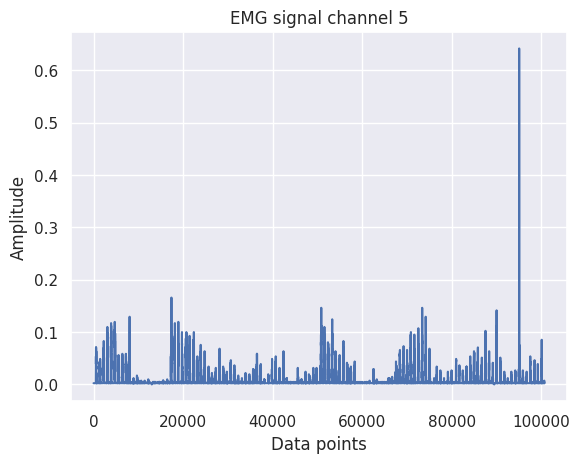

In [3]:
# Check datastructure
data = loadmat(subject_data_path)
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

emg = data["emg"]                 # shape: (T, n_channels)
stimulus = data["restimulus"]     # corrected labels
repetition = data["rerepetition"] # corrected repetition indices

print("EMG data dimension : {}".format(emg.shape))
print("EMG data type : {}".format(type(emg)))

# Plot first channel
plt.close("all")
fig, ax = plt.subplots()
EMG_channel = 5
ax.plot(emg[:,EMG_channel])
ax.set_title(f"EMG signal channel {EMG_channel}")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

In [4]:
n_stimuli = len(np.unique(stimulus)) - 1 # -1 because 0 is the resting condition
n_repetitions = len(np.unique(repetition)) - 1 # -1 because 0 is not a repetition

mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)] 
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

## 3. Feature extraction & visualization

In [5]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)


dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std]
    # features=[mav, std, maxav, rms, wl, ssc] # Uncomment this line to use all features once implemented
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")

dataset dimension: (120, 20)
labels dimension: (120,)


## 4. Gradient boosting classification

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    dataset, labels, test_size=0.4, stratify=labels, random_state=0
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=0
)

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z = scaler.transform(X_val)
X_test_z = scaler.transform(X_test)


In [7]:
gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train_z, y_train)

y_val_pred = gb.predict(X_val_z)
print("Baseline val accuracy:", accuracy_score(y_val, y_val_pred))
print("Baseline val macro-F1:", f1_score(y_val, y_val_pred, average="macro"))


Baseline val accuracy: 0.875
Baseline val macro-F1: 0.8444444444444444


### Hyperparameter optimization

In [ ]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4],
    "subsample": [0.7, 1.0],
    "max_features": ["sqrt", None],
}

gb_base = GradientBoostingClassifier(random_state=0)

grid = GridSearchCV(
    gb_base,
    param_grid,
    scoring="accuracy",      # or "f1_macro"
    cv=5,
    n_jobs=-1
)
grid.fit(X_train_z, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best_gb = grid.best_estimator_


In [ ]:
y_val_pred = best_gb.predict(X_val_z)
print("Val accuracy:", accuracy_score(y_val, y_val_pred))
print("Val macro-F1:", f1_score(y_val, y_val_pred, average="macro"))

y_test_pred = best_gb.predict(X_test_z)
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Test macro-F1:", f1_score(y_test, y_test_pred, average="macro"))


In [ ]:
confmat = confusion_matrix(y_test, y_test_pred, labels=np.unique(labels))
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label");


## 5. Performance metric & interpretation

For a multi-class, almost balanced task with 12 actions, you can sensibly use:

Primary metric: macro-averaged F1

gives equal weight to each class, so classes with fewer samples aren’t “hidden” by majority classes.

Secondary metric: overall accuracy

easy to interpret for a classifier.

In the report, something like:

“We report macro-averaged F1 as the primary metric, because it treats all movement classes equally and is robust to potential class imbalance. Overall accuracy is also given as a simple measure of the fraction of correctly classified trials.”

Then discuss whether, e.g., >80% accuracy / macro-F1 looks good for single-subject EMG, and mention confusion between similar movements (e.g. flexion/extension pairs).

## 6. Feature selection / dimension reduction

In [ ]:
mi = mutual_info_classif(X_train_z, y_train, random_state=0)
k = 20  # choose e.g. top 20 features

selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X_train_z, y_train)

X_train_fs = selector.transform(X_train_z)
X_val_fs = selector.transform(X_val_z)
X_test_fs = selector.transform(X_test_z)

gb_fs = GradientBoostingClassifier(random_state=0, **grid.best_params_)
gb_fs.fit(X_train_fs, y_train)

print("FS Test accuracy:", accuracy_score(y_test, gb_fs.predict(X_test_fs)))
print("FS Test macro-F1:", f1_score(y_test, gb_fs.predict(X_test_fs), average="macro"))


In [ ]:
pca = PCA(n_components=0.95, svd_solver="full")  # keep 95% variance
pca.fit(X_train_z)

X_train_pca = pca.transform(X_train_z)
X_val_pca = pca.transform(X_val_z)
X_test_pca = pca.transform(X_test_z)

gb_pca = GradientBoostingClassifier(random_state=0, **grid.best_params_)
gb_pca.fit(X_train_pca, y_train)

print("PCA Test accuracy:", accuracy_score(y_test, gb_pca.predict(X_test_pca)))
print("PCA Test macro-F1:", f1_score(y_test, gb_pca.predict(X_test_pca), average="macro"))
